Root Mean Squared Error (RMSE): 122591.43626525516


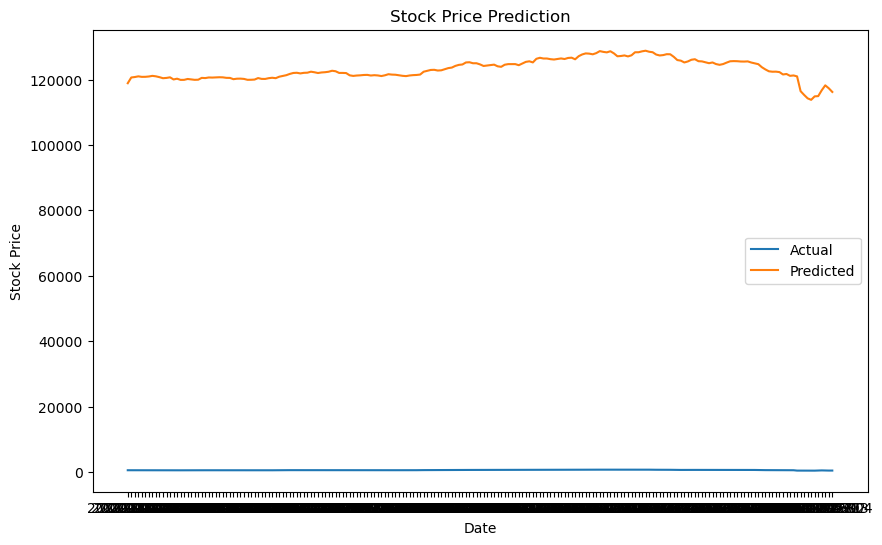

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import matplotlib.pyplot as plt

data = pd.read_csv('NFLX.csv')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

class LSTM:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.W = np.random.uniform(size=(input_dim, hidden_dim), low=-.01, high=.01)
        self.U = np.random.uniform(size=(hidden_dim, hidden_dim), low=-.01, high=.01)
        self.V = np.random.uniform(size=(hidden_dim, output_dim), low=-.01, high=.01)

    def forward_propagation(self, inputs):
        self.h = np.zeros((inputs.shape[0], self.hidden_dim))
        self.y = np.zeros((inputs.shape[0], self.output_dim))
        for t in range(inputs.shape[0]):
            self.h[t] = np.tanh(np.dot(inputs[t], self.W) + np.dot(self.h[t - 1], self.U))
            self.y[t] = np.dot(self.h[t], self.V)
        return self.y

def train_model(X_train, y_train, input_dim, hidden_dim, output_dim):
    model = LSTM(input_dim, hidden_dim, output_dim)
    y_pred = model.forward_propagation(X_train)
    loss = mean_squared_error(y_train, y_pred)
    return loss

input_dim = 1
hidden_dim = 1
output_dim = 1
X_train, X_val, y_train, y_val = train_test_split(train_data[:-1], train_data[1:], test_size=0.2)
func = lambda params: train_model(X_train, y_train, input_dim, hidden_dim, output_dim)
params = minimize(func, x0=np.random.uniform(size=input_dim + hidden_dim + output_dim), method='L-BFGS-B')
best_params = params.x

def predict_stock_prices(X_test, input_dim, hidden_dim, output_dim):
    model = LSTM(input_dim, hidden_dim, output_dim)
    model.W = best_params[:input_dim * hidden_dim].reshape(input_dim, hidden_dim)
    model.U = best_params[input_dim * hidden_dim: (input_dim + hidden_dim) * hidden_dim].reshape(hidden_dim, hidden_dim)
    model.V = best_params[(input_dim + hidden_dim) * hidden_dim:].reshape(hidden_dim, output_dim)
    y_pred = model.forward_propagation(X_test)
    return scaler.inverse_transform(y_pred)

X_test = test_data[:-1]
y_test = test_data[1:]

predicted_prices = predict_stock_prices(X_test, input_dim, hidden_dim, output_dim)

predicted_prices = scaler.inverse_transform(predicted_prices)
y_test = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test, predicted_prices))
print("Root Mean Squared Error (RMSE):", rmse)

plt.figure(figsize=(10, 6))
plt.plot(data['Date'][train_size+1:], y_test.flatten(), label='Actual')
plt.plot(data['Date'][train_size+1:], predicted_prices.flatten(), label='Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()